# Attacks

# imports

In [2]:
from utils.TS2Vec.ts2vec import TS2Vec
from utils.TS2Vec import datautils

import os

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import pickle

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

from utils.estimation import (plot_aa_metrics, rejection_curves_procedure, 
                              build_basic_dict_curve, build_custom_dict_curve,
                             draw_rejection_curves)
from utils.attacks import ifgsm_procedure

In [2]:
class CustomTrainDS(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        X = self.X[idx, :]
        y = self.y[idx]
        return X, y

    
    
    
class Net(nn.Module):
    def __init__(self, emb_size, out_size):
        super().__init__()
        
        self.classifier = nn.Sequential(
            nn.Linear(emb_size, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 32), 
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, out_size)
        )
        self.sigm = nn.Sigmoid()
        
    def forward(self, x):
        out = self.classifier(x)
        return self.sigm(out)
    
class TS2VecClassifier(nn.Module):
    def __init__(self, te2vec_model, emb_size, n_classes):
        super().__init__()
        
        if n_classes == 2:
            output_size = 1
        else:
            output_size = n_classes
        
        self.emd_model = te2vec_model
        self.classifier = Net(emb_size, output_size)
        
    def forward(self, X, mask=None):
        
            emb_out = self.emd_model(X, mask)
            emb_out = F.max_pool1d(emb_out.transpose(1, 2), kernel_size = emb_out.size(1))
            emb_out = emb_out.transpose(1, 2).squeeze(1)
            out = self.classifier(emb_out)
            
            return out
        
    def load(self, path_dict: dict):
        self.emd_model.load_state_dict(torch.load(path_dict['emb']))
        self.classifier.load_state_dict(torch.load(path_dict['class']))

# Training models

In [3]:
class MLP:
    def __init__(self, device='cpu', def_save_path='MLP_weights/experiments/exp.pt', 
                 n_classes=2, emb_size=512, batch_size=1):
        
        
        if n_classes > 2:
            self.loss = nn.CrossEntropyLoss()
            output_size = n_classes
        else:
            self.loss = nn.BCELoss()
            output_size = 1
        
        
        self.device = device
        self.save_path = def_save_path
        self.model = Net(emb_size, output_size).to(self.device)
        self.batch_size = batch_size
        self.n_classes = n_classes
        

        
    def fit(self, X, y, batch_size=64, lr=0.001, sch_patience=17, 
            early_stop_patience=60, num_epochs=1000, verbose=False):
        
        
        self.batch_size = batch_size
        # data transformation
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        classes = torch.unique(y, return_counts=True)
        
        test_size = 0.2
        #print()
        if torch.min(classes[1]) == 1 or test_size*len(X) <= len(classes[0]) :
            X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size)
        else:
            X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, stratify=y)
        
        #print(self.batch_size, len(X_train), len(X_val))
        if len(X_train) < self.batch_size or len(X_val) < self.batch_size:
            self.batch_size = min(len(X_train), len(X_val))
        
        #print(type(self.batch_size))
        train_set = CustomTrainDS(X_train, y_train)
        train_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True, drop_last=True)

        test_set = CustomTrainDS(X_val, y_val)
        test_loader = DataLoader(test_set, batch_size=self.batch_size, shuffle=False, drop_last=True)       
        
        
        if self.n_classes > 2:
            self.loss = nn.CrossEntropyLoss()
            out_size = n_classes
        else:
            self.loss = nn.BCELoss()
            out_size = 1
            
                #model inicialization
        self.model = Net(X.shape[1], out_size).to(self.device)
            
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, 1, gamma=0.1)
        
        
        #model training
        max_metric = 0
        patient = 0
        
        self.save(self.save_path)
        
        for epoch in range(num_epochs):

            train_loss, acc_train = self.train_step(train_loader)
            test_loss, acc_test = self.valid_step(test_loader) 
            
            if verbose:
                print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; acc_train {acc_train:.3f}; test loss: {test_loss:.3f}; acc_test {acc_test:.3f}')
            
            if acc_test > max_metric:
                max_metric = acc_test
                patient = 0
                self.save(self.save_path)
            else:
                patient += 1
                
            if patient == sch_patience:
                self.scheduler.step()
            
            elif patient == early_stop_patience:
                if verbose:
                    print('EARLY STOP')
                break
        
        self.load(self.save_path)

            
    def train_step(self, loader):
        losses, n_batches = 0, 0
        self.model.train(True)

        all_y_true = []
        all_y_pred = []
        for x, labels in loader:

            self.optimizer.zero_grad()
            
            x = x.to(self.device)
            all_y_true.extend(labels.detach().numpy().tolist())
            labels = labels.to(self.device)

            y_out = self.model(x)
            all_y_pred.extend(torch.argmax(y_out, axis=1).cpu().detach().numpy().astype(int).tolist())
            
            #print(y_out.device, labels.device)
            loss = self.loss(y_out, labels) 
            loss.backward()     
            self.optimizer.step()
            
            losses += loss
            n_batches += 1

        mean_loss = losses / n_batches
        acc = accuracy_score(all_y_true, all_y_pred)
        return mean_loss, acc
    
    
    def valid_step(self, loader):
    
        losses, n_batches = 0, 0
        self.model.eval()

        all_y_true = []
        all_y_pred = []
    
        for x, labels in loader:
            with torch.no_grad():
                x = x.to(self.device)
                all_y_true.extend(labels.detach().numpy().tolist())
                labels = labels.to(self.device)

                y_out = self.model(x)
                
                if self.n_classes > 2:
                    pred_class = torch.argmax(y_out, axis=1).cpu().detach().numpy().astype(int).tolist()
                else:
                    pred_class = torch.round_(y_out).cpu().detach().numpy().astype(int).tolist()
                
                all_y_pred.extend(pred_class)

                loss = self.loss(y_out, labels)
                losses += loss
                n_batches += 1

        mean_loss = losses / n_batches
        acc = accuracy_score(all_y_true, all_y_pred)
        return mean_loss, acc

    def predict(self, X):
        X = torch.tensor(X, dtype=torch.float32)
        
        test_set = CustomTestDS(X)
        test_loader = DataLoader(test_set, batch_size=self.batch_size, 
                                 shuffle=False, drop_last=False)
        
        losses, n_batches = 0, 0
        self.model.eval()

        all_y_pred = []
    
        for x in test_loader:
            with torch.no_grad():
                x = x.to(self.device)
                y_out = self.model(x)
                
                if self.n_classes > 2:
                    pred_class = torch.argmax(y_out, axis=1).cpu().detach().numpy().astype(int).tolist()
                else:
                    pred_class = torch.round_(y_out).cpu().detach().numpy().astype(int).tolist()
                
                all_y_pred.extend(pred_class)
        
        return all_y_pred
    
    def predict_adv(self, X):
                
        losses, n_batches = 0, 0
        self.model.train()
        
        x = X.to(self.device)
        y_out = self.model(x)
        
        return y_out
    
    def save(self, path):
        torch.save(self.model.state_dict(), path)
    
    def load(self, path):
        self.model.load_state_dict(torch.load(path))
        

In [4]:
    
class CustomTestDS(Dataset):
    def __init__(self, X):
        self.X = X        
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        X = self.X[idx, :]
        return X
    
def calculate_metrics(y_true, y_pred):
    
    method = 'binary'
    
    if len(np.unique(y_true)) > 2:
        method = 'weighted'

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=method)
    recall = recall_score(y_true, y_pred, average=method)
    f1 = f1_score(y_true, y_pred, average=method)
    
    return [acc, prec, recall, f1]

In [5]:
def get_embeddings_dataset(dataset_name, glob_dataset_name='UCR', max_pooling=True, batch_size=8, device='cpu'):
    
    
    if glob_dataset_name == 'UCR':
        train_data, train_labels, test_data, test_labels = datautils.load_UCR(dataset_name)
    elif glob_dataset_name == 'UEA':
        train_data, train_labels, test_data, test_labels = datautils.load_UEA(dataset_name)
    else:
        raise ValueError('Incorrect global_dataset_name')
        
    train_data = np.where(np.isnan(train_data), 0, train_data)
    test_data = np.where(np.isnan(test_data), 0, test_data)

    model = TS2Vec(
        input_dims=train_data.shape[-1],
        device=device,
        output_dims=320,
        batch_size = batch_size
    )
    
    loss_log = model.fit(
            train_data,
            verbose=False
        )
    print('Trained')
    if max_pooling:
        train_repr = model.encode(train_data, casual=True, sliding_length=1, sliding_padding=50)
        test_repr = model.encode(test_data, casual=True, sliding_length=1, sliding_padding=50)
        train_repr = np.max(train_repr, axis=1)
        test_repr = np.max(test_repr, axis=1)
        
    else:
        train_repr = model.encode(train_data, encoding_window='full_series')
        test_repr = model.encode(test_data, encoding_window='full_series')
        

    return (train_repr, train_labels, test_repr, test_labels), model

In [6]:
def train_one_dataset(glob_dataset_name='UCR', 
                      dataset_name='Coffee',
                      max_pooling=False, 
                      batch_size=8, 
                      device='cpu', 
                      model_id=0):
        
#         if device != 'cpu':
#             torch.cuda.empty_cache()

        save_name = f'{dataset_name}_{model_id}'
        emb_name = f'checkpoints/TS2Vec/emb_models/{glob_dataset_name}/{save_name}.pt'
        
        res = get_embeddings_dataset(dataset_name, glob_dataset_name, max_pooling, batch_size, device)
        data, emb_model = res
        train_emb, train_labels, test_emb, test_labels = data
        torch.save(emb_model.net.state_dict(), emb_name)

        print('Training classifier')
        mlp_save_path = f'checkpoints/TS2Vec/class_models/{glob_dataset_name}/{save_name}.pt'
        class_model = MLP(device=device, def_save_path=mlp_save_path)
        class_model.fit(train_emb, train_labels.reshape(-1, 1), verbose=False)
        
        test_pred = class_model.predict(test_emb)
        metrics = calculate_metrics(test_labels, test_pred)
        
        return metrics
        

def experiments(glob_dataset_name='UCR', max_pooling=False, batch_size=8, device='cpu', model_id='0'):

    all_datasets = os.listdir(f'data/TS2Vec/{glob_dataset_name}')

    skip_list = ['Missing_value_and_variable_length_datasets_adjusted', 'UCRArchive_2018.zip', 'Descriptions',
                'Multivariate2018_arff.zip', 'EigenWorms', 'Images']

    with open(f'data/TS2Vec/dict_bin_datasets.pickle', 'rb') as f:
        dict_bin_datasets = pickle.load(f)
        
    bin_datasets = dict_bin_datasets[glob_dataset_name]
    
    df_res = pd.DataFrame([], columns = ['Dataset', 'Acc', 'Pr', 'Rc', 'F1'])
    for dataset_name in tqdm(bin_datasets):

        if dataset_name in skip_list:
            continue

        print(f'******** {dataset_name} ********')
        if device != 'cpu':
            torch.cuda.empty_cache()

        metrics = train_one_dataset(glob_dataset_name=glob_dataset_name, dataset_name=dataset_name, 
                                    max_pooling=max_pooling, batch_size=batch_size, device=device, model_id=model_id)
        line = [dataset_name] + metrics
        line = dict(zip(df_res.columns.tolist(), line))
        df_res = df_res.append(line, ignore_index=True)

        path_to_save = f'results/TS2Vec/df_metrics_{glob_dataset_name}_{model_id}.csv'
        df_res.to_csv(path_to_save, index=False)
        
        print()
        
    return df_res

In [7]:
# glob_dataset_name = 'UEA'
# max_pooling = False

# device = 'cuda:1'
# batch_size=8
# for model_id in tqdm(range(5)):
#     torch.manual_seed(model_id)
#     df_res = experiments(glob_dataset_name=glob_dataset_name, max_pooling=max_pooling, 
#                      batch_size=batch_size, device=device, model_id=model_id)
    

In [8]:
# glob_dataset_name = 'UEA'
# dataset_name = 'SelfRegulationSCP1'
# max_pooling = False

# device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# batch_size=8
    
# for model_id in tqdm(range(5)):
#     torch.manual_seed(model_id)
#     res = train_one_dataset(glob_dataset_name=glob_dataset_name, dataset_name=dataset_name, max_pooling=max_pooling, 
#                                        batch_size=batch_size, device=device, model_id=model_id)

#     print(res)

# loading data and model

In [9]:
# # Load the ECG200 dataset from UCR archive
# max_pooling = False

# model_id = 0

# glob_dataset_name = 'UEA'
# dataset_name = 'Wine'

# device = 'cuda:1'
# batch_size = 4 if glob_dataset_name == 'UEA' else 8
    
# if glob_dataset_name == 'UCR':
#     train_data, train_labels, test_data, test_labels = datautils.load_UCR(dataset_name)
    
# elif glob_dataset_name == 'UEA':
#     train_data, train_labels, test_data, test_labels = datautils.load_UEA(dataset_name)
    
# train_data = np.where(np.isnan(train_data), 0, train_data)
# test_data = np.where(np.isnan(test_data), 0, test_data)

# emb_model = TS2Vec(
#         input_dims=train_data.shape[-1],
#         device=device,
#         output_dims=320,
#         batch_size = batch_size
#     )

# model = TS2VecClassifier(emb_model.net, emb_size=320, n_classes=2)

# path_dict = {'emb': f'checkpoints/TS2Vec/emb_models/{glob_dataset_name}/{dataset_name}_{model_id}.pt',
#                 'class': f'checkpoints/TS2Vec/class_models/{glob_dataset_name}/{dataset_name}_{model_id}.pt'}

# model.load(path_dict)
# model = model.to(device)

# dataset = CustomTrainDS(torch.from_numpy(test_data).to(torch.float), torch.from_numpy(test_labels).to(torch.float))
# dr_last = len(dataset) // batch_size != len(dataset) / batch_size
# test_loader = DataLoader(dataset, batch_size=batch_size, drop_last=False)

# Attack

In [10]:
# n_iters = 50
# eps_params = (1e-3, 1e0, 5)
# n_objects = test_labels.shape[0]
# criterion = torch.nn.BCELoss()

# device= torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# device= torch.device('cpu')

# model = model.to(device)
# train_mode = False

# aa_res_df, rej_curves_dict = ifgsm_procedure(model=model, loader=test_loader, dataset=CustomTrainDS,
#                                              criterion=criterion, eps_params=eps_params, 
#                                              n_steps=n_iters, batch_size=batch_size, 
#                                              device=device, n_objects=n_objects, train_mode=train_mode)

# aa_res_df.to_csv(f'results/TS2Vec/{glob_dataset_name}/aa_res_{dataset_name}_{model_id}.csv')
# with open(f'results/TS2Vec/{glob_dataset_name}/rej_curves_dict_model_{dataset_name}_{model_id}.pickle', 'wb') as file:
#     pickle.dump(rej_curves_dict, file)

In [11]:
# # Load the ECG200 dataset from UCR archive
# max_pooling = False

# glob_dataset_name = 'UCR'

# dataset_name = 'Wine'

# device = 'cuda:1'
# batch_size = 4 if glob_dataset_name == 'UEA' else 8
    
# if glob_dataset_name == 'UCR':
#     train_data, train_labels, test_data, test_labels = datautils.load_UCR(dataset_name)
    
# elif glob_dataset_name == 'UEA':
#     train_data, train_labels, test_data, test_labels = datautils.load_UEA(dataset_name)


# train_data = np.where(np.isnan(train_data), 0, train_data)
# test_data = np.where(np.isnan(test_data), 0, test_data)

# emb_model = TS2Vec(
#         input_dims=train_data.shape[-1],
#         device=device,
#         output_dims=320,
#         batch_size = batch_size
#     )

# model = TS2VecClassifier(emb_model.net, emb_size=320, n_classes=2)

# n_iters = 50
# eps_params = (1e-3, 1e0, 5)
# n_objects = test_labels.shape[0]
# criterion = torch.nn.BCELoss()

# for model_id in tqdm(range(5)):
    
#     print(f'######################### model_id:{model_id} #########################')

#     path_dict = {'emb': f'checkpoints/TS2Vec/emb_models/{glob_dataset_name}/{dataset_name}_{model_id}.pt',
#                     'class': f'checkpoints/TS2Vec/class_models/{glob_dataset_name}/{dataset_name}_{model_id}.pt'}

#     model.load(path_dict)
#     model = model.to(device)

#     dataset = CustomTrainDS(torch.from_numpy(test_data).to(torch.float), torch.from_numpy(test_labels).to(torch.float))
#     dr_last = len(dataset) // batch_size != len(dataset) / batch_size
#     test_loader = DataLoader(dataset, batch_size=batch_size, drop_last=False)
    
#     aa_res_df, rej_curves_dict = ifgsm_procedure(model=model, loader=test_loader, dataset=CustomTrainDS,
#                                              criterion=criterion, eps_params=eps_params, 
#                                              n_steps=n_iters, device=device,
#                                              batch_size=batch_size, n_objects=n_objects)

#     aa_res_df.to_csv(f'results/TS2Vec/{glob_dataset_name}/aa_res_{dataset_name}_{model_id}.csv')
#     with open(f'results/TS2Vec/{glob_dataset_name}/rej_curves_dict_model_{dataset_name}_{model_id}.pickle', 'wb') as file:
#         pickle.dump(rej_curves_dict, file)

In [12]:
# Load the ECG200 dataset from UCR archive
max_pooling = False

glob_dataset_name = 'UEA'
adv = ''

device = 'cuda:1'
batch_size = 4 if glob_dataset_name == 'UEA' else 8
    
with open(f'data/TS2Vec/dict_bin_datasets.pickle', 'rb') as f:
    dict_bin_datasets = pickle.load(f)

bin_datasets = dict_bin_datasets[glob_dataset_name]

for dataset_name in tqdm(bin_datasets):
    print(f'######################### dataset_name:{dataset_name} #########################')

    if glob_dataset_name == 'UCR':
        train_data, train_labels, test_data, test_labels = datautils.load_UCR(dataset_name)

    elif glob_dataset_name == 'UEA':
        train_data, train_labels, test_data, test_labels = datautils.load_UEA(dataset_name)
        
    train_data = np.where(np.isnan(train_data), 0, train_data)
    test_data = np.where(np.isnan(test_data), 0, test_data)

    emb_model = TS2Vec(
            input_dims=train_data.shape[-1],
            device=device,
            output_dims=320,
            batch_size = batch_size
        )

    model = TS2VecClassifier(emb_model.net, emb_size=320, n_classes=2)

    n_iters = 50
    eps_params = (1e-3, 1e0, 5)
    n_objects = test_labels.shape[0]
    criterion = torch.nn.BCELoss()

    for model_id in tqdm(range(5)):

        path_dict = {'emb': f'checkpoints/TS2Vec/emb_models{adv}/{glob_dataset_name}/{dataset_name}_{model_id}.pt',
                        'class': f'checkpoints/TS2Vec/class_models{adv}/{glob_dataset_name}/{dataset_name}_{model_id}.pt'}

        model.load(path_dict)
        model = model.to(device)

        dataset = CustomTrainDS(torch.from_numpy(test_data).to(torch.float), torch.from_numpy(test_labels).to(torch.float))
        dr_last = len(dataset) // batch_size != len(dataset) / batch_size
        test_loader = DataLoader(dataset, batch_size=batch_size, drop_last=False)

        aa_res_df, rej_curves_dict = ifgsm_procedure(model=model, loader=test_loader, dataset=CustomTrainDS,
                                                 criterion=criterion, eps_params=eps_params, 
                                                 n_steps=n_iters, device=device,
                                                 batch_size=batch_size, n_objects=n_objects)

        aa_res_df.to_csv(f'results/TS2Vec/{glob_dataset_name}/aa_res_{dataset_name}_{model_id}{adv}.csv')
        with open(f'results/TS2Vec/{glob_dataset_name}/rej_curves_dict_model_{dataset_name}_{model_id}{adv}.pickle', 'wb') as file:
            pickle.dump(rej_curves_dict, file)

  0%|          | 0/6 [00:00<?, ?it/s]

######################### dataset_name:MotorImagery #########################


KeyboardInterrupt: 

In [3]:
aa_res_df = pd.read_csv(f'results/TS2Vec/UCR/aa_res_FordA_{0}.csv', index_col=0)
aa_res_df

,n steps,ACC,ROC AUC,PR AUC,eps
0,0,0.929545,0.928678,0.904512,0.001
1,1,0.929545,0.928678,0.904512,0.001
2,2,0.926515,0.925644,0.900087,0.001
3,3,0.925000,0.924079,0.898481,0.001
4,4,0.922727,0.921780,0.895475,0.001
...,...,...,...,...,...
46,46,0.000000,0.000000,0.484091,1.000
47,47,0.000000,0.000000,0.484091,1.000
48,48,0.000000,0.000000,0.484091,1.000
49,49,0.000000,0.000000,0.484091,1.000


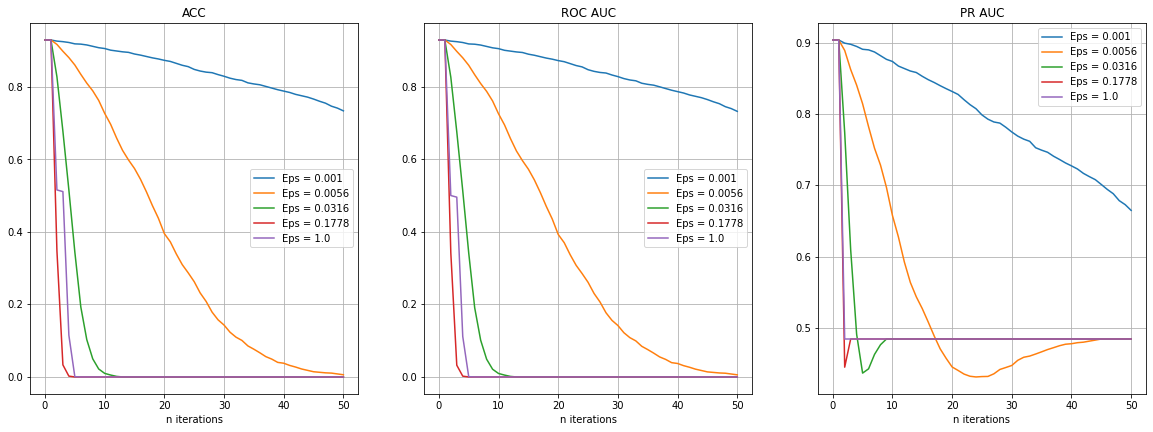

In [18]:
plot_aa_metrics(aa_res_df, method='metric')

# Rejection Curves

In [13]:
def build_load_path(glob_dataset_name, dataset_name, adv='', n_models=5):
    
    list_load = []
    
    for model_id in range(n_models):
        path_dict = {'emb': f'checkpoints/TS2Vec/emb_models{adv}/{glob_dataset_name}/{dataset_name}_{model_id}.pt',
                'class': f'checkpoints/TS2Vec/class_models{adv}/{glob_dataset_name}/{dataset_name}_{model_id}.pt'}
        list_load.append(path_dict)
        
    return list_load

def load_TS2Vec(model, model_path):
    model.load(model_path)
    return model

In [14]:
# Load the ECG200 dataset from UCR archive
max_pooling = False
random_state = 0

glob_dataset_name = 'UCR'
dataset_name = 'FordA'

device = 'cuda:1'
batch_size = 4 if glob_dataset_name == 'UEA' else 8

criterion = torch.nn.BCELoss()
    
if glob_dataset_name == 'UCR':
    train_data, train_labels, test_data, test_labels = datautils.load_UCR(dataset_name)
    
elif glob_dataset_name == 'UEA':
    train_data, train_labels, test_data, test_labels = datautils.load_UEA(dataset_name)

emb_model = TS2Vec(
        input_dims=train_data.shape[-1],
        device=device,
        output_dims=320,
        batch_size = batch_size
    )

model = TS2VecClassifier(emb_model.net, emb_size=320, n_classes=2)

X_correct = torch.from_numpy(test_data).to(torch.float)
y_correct = torch.from_numpy(test_labels).to(torch.float).reshape(-1, 1)

dataset = CustomTrainDS(X_correct, y_correct)
dr_last = len(dataset) // batch_size != len(dataset) / batch_size
test_loader = DataLoader(dataset, batch_size=batch_size, drop_last=False)

In [15]:

y_test = test_labels.reshape(-1, 1)

load_path = build_load_path(glob_dataset_name, dataset_name)


preds, norms = rejection_curves_procedure(model, test_loader,
                               criterion, load_TS2Vec, load_path, y_test, device,
                               n_models=5)

0th models Accuracy 0.930, ROC-AUC 0.929, PR-AUC 0.905
1th models Accuracy 0.925, ROC-AUC 0.925, PR-AUC 0.889
2th models Accuracy 0.914, ROC-AUC 0.914, PR-AUC 0.871
3th models Accuracy 0.933, ROC-AUC 0.933, PR-AUC 0.903
4th models Accuracy 0.905, ROC-AUC 0.906, PR-AUC 0.855


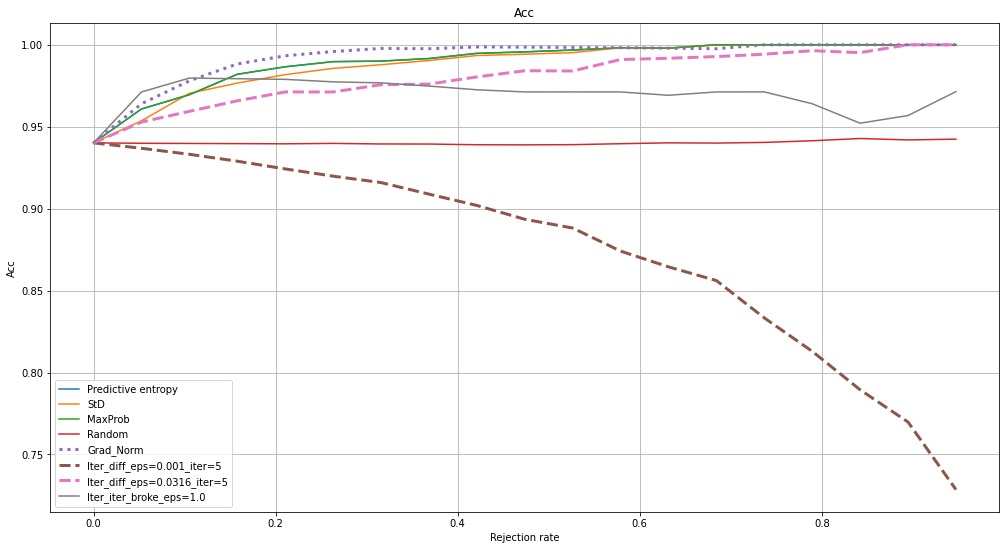

In [19]:
model_id = 0

with open(f'results/TS2Vec/{glob_dataset_name}/rej_curves_dict_model_{dataset_name}_{model_id}.pickle', 'rb') as file:
    rej_curves_dict = pickle.load(file)


rejection_rates = np.linspace(0, 1.0, 20)
iter_to_break = 5
dict_metrics = {'Acc':accuracy_score,
               #'ROC AUC':roc_auc_score,
               #'PR AUC':average_precision_score
               }

all_eps = list(rej_curves_dict.keys())


dict_curves = build_basic_dict_curve(y_test, preds, norms, rejection_rates, dict_metrics)
dict_curves = build_custom_dict_curve(dict_curves, y_test, preds, norms, rejection_rates, 
                                     dict_metrics, rej_curves_dict, all_eps, iter_to_break)

draw_rejection_curves(dict_curves, rejection_rates)

#### getting table with attacks

In [11]:
def calculate_ROC_RC(list_curve_points):
    
    val = np.array(list_curve_points)
    val_start = val[:-1]
    val_post = val[1:]

    val_mean = np.sum(np.array([val_start, val_post]))/(2*(len(list_curve_points)-1))
    
    return val_mean


def get_table_ROC_RC(dict_curves):

    df_ROC_RC = pd.DataFrame(columns=['metric', 'method', 'value'])

    for metric_name, dict_curve_metric in dict_curves.items():

        for method_name, list_val in dict_curve_metric.items():
            val_mean = calculate_ROC_RC(list_val)

            dict_res = dict(zip(df_ROC_RC.columns,[metric_name, method_name, val_mean]))
            df_ROC_RC = df_ROC_RC.append(dict_res, ignore_index=True)

    return df_ROC_RC


def change_rej_curves(rej_curves_dict, y_test_size):
    for eps in rej_curves_dict:
        dict_loc = rej_curves_dict[eps]['diff']
        for iter_ in dict_loc:
            dict_loc[iter_] = dict_loc[iter_][:y_test_size]
        
        rej_curves_dict[eps]['diff'] = dict_loc
        rej_curves_dict[eps]['iter_broke'] = rej_curves_dict[eps]['iter_broke'][:y_test_size]
    
    return rej_curves_dict


In [15]:
max_pooling = False
random_state = 0
model_id = 0


glob_dataset_name = 'UEA'
adv = ''

device = 'cuda:1'
batch_size = 4 if glob_dataset_name == 'UEA' else 8
    
with open(f'data/TS2Vec/dict_bin_datasets.pickle', 'rb') as f:
    dict_bin_datasets = pickle.load(f)

bin_datasets = dict_bin_datasets[glob_dataset_name]

criterion = torch.nn.BCELoss()

rejection_rates = np.linspace(0, 1.0, 20)
iter_to_break = 5
dict_metrics = {'Acc':accuracy_score,
               #'PR AUC':average_precision_score
               }


table_ROC_RC = pd.DataFrame([])
    
for dataset_name in tqdm(bin_datasets):
    print(f'######################### dataset_name:{dataset_name} #########################')

    if glob_dataset_name == 'UCR':
        _, _, test_data, test_labels = datautils.load_UCR(dataset_name)

    elif glob_dataset_name == 'UEA':
        _, _, test_data, test_labels = datautils.load_UEA(dataset_name)
        
    test_data = np.where(np.isnan(test_data), 0, test_data)


    emb_model = TS2Vec(
            input_dims=test_data.shape[-1],
            device=device,
            output_dims=320,
            batch_size = batch_size
        )

    model = TS2VecClassifier(emb_model.net, emb_size=320, n_classes=2)

    X_correct = torch.from_numpy(test_data).to(torch.float)
    y_correct = torch.from_numpy(test_labels).to(torch.float).reshape(-1, 1)

    dataset = CustomTrainDS(X_correct, y_correct)
    dr_last = len(dataset) // batch_size != len(dataset) / batch_size
    test_loader = DataLoader(dataset, batch_size=batch_size, drop_last=True)

    y_test_size = len(test_loader)*batch_size
    y_test = test_labels[:y_test_size].reshape(-1, 1)

    load_path = build_load_path(glob_dataset_name, dataset_name, adv=adv)

    preds, norms = rejection_curves_procedure(model, test_loader,
                                   criterion, load_TS2Vec, load_path, y_test, device,
                                   n_models=5)

    with open(f'results/TS2Vec/{glob_dataset_name}/rej_curves_dict_model_{dataset_name}_{model_id}{adv}.pickle', 'rb') as file:
        rej_curves_dict = pickle.load(file)
        
    rej_curves_dict = change_rej_curves(rej_curves_dict, y_test_size)
        
    all_eps = list(rej_curves_dict.keys())

    dict_curves = build_basic_dict_curve(y_test, preds, norms, rejection_rates, dict_metrics)
    dict_curves = build_custom_dict_curve(dict_curves, y_test, preds, norms, rejection_rates, 
                                         dict_metrics, rej_curves_dict, all_eps, iter_to_break)
    
    df_ROC_RC = get_table_ROC_RC(dict_curves)
    df_ROC_RC['dataset'] = dataset_name 
    table_ROC_RC = pd.concat([table_ROC_RC, df_ROC_RC])
    
table_ROC_RC.to_csv(f'results/TS2Vec/{glob_dataset_name}_ROC_RC_{adv}_inverse.csv')

  0%|          | 0/6 [00:00<?, ?it/s]

######################### dataset_name:MotorImagery #########################
0th models Accuracy 0.440, ROC-AUC 0.440, PR-AUC 0.476
1th models Accuracy 0.530, ROC-AUC 0.530, PR-AUC 0.516
2th models Accuracy 0.500, ROC-AUC 0.500, PR-AUC 0.500
3th models Accuracy 0.590, ROC-AUC 0.590, PR-AUC 0.552
4th models Accuracy 0.490, ROC-AUC 0.490, PR-AUC 0.495
######################### dataset_name:SelfRegulationSCP2 #########################
0th models Accuracy 0.522, ROC-AUC 0.522, PR-AUC 0.512
1th models Accuracy 0.533, ROC-AUC 0.533, PR-AUC 0.518
2th models Accuracy 0.522, ROC-AUC 0.522, PR-AUC 0.515
3th models Accuracy 0.522, ROC-AUC 0.522, PR-AUC 0.512
4th models Accuracy 0.544, ROC-AUC 0.544, PR-AUC 0.523
######################### dataset_name:SelfRegulationSCP1 #########################
0th models Accuracy 0.829, ROC-AUC 0.830, PR-AUC 0.751
1th models Accuracy 0.873, ROC-AUC 0.873, PR-AUC 0.816
2th models Accuracy 0.842, ROC-AUC 0.843, PR-AUC 0.773
3th models Accuracy 0.753, ROC-AUC 0.75

In [ ]:
glob_dataset_name

In [ ]:
table_ROC_RC

In [ ]:
a = np.arange(12).reshape(3, 4)

np.mean(a, axis=0)

# ADV training

In [ ]:
def req_grad(model: nn.Module, state: bool = True) -> None:
    """Set requires_grad of all model parameters to the desired value.

    :param model: the model
    :param state: desired value for requires_grad
    """
    for param in model.parameters():
        param.requires_grad_(state)

def prepare_adv_data(
        model: nn.Module,  # model for attack
        loader: DataLoader,  # dataloader with data
        criterion: nn.Module,
        eps: float,
        device='cpu',
        train_mode=False):  # params_dict with eps and iter number

    model.train(train_mode)
    req_grad(model, state=False)  # detach all model's parameters

    all_y_true = torch.tensor([]) # logging y_true for rebuilding dataloader and calculation difference with preds
    x_adv_tensor = torch.FloatTensor([])  # logging x_adv for rebuilding dataloader

    for x, y_true in loader:
        
        all_y_true = torch.cat((all_y_true, y_true.cpu().detach()), dim=0)
        x.grad = None
        x.requires_grad = True

        # prediction for original input
        x = x.to(device, non_blocking=True)
        y_true = y_true.to(device)
        
        y_pred = model(x)

        # attack for adv input
        
        loss_val = criterion(y_pred, y_true.reshape(-1, 1))
        grad_ = torch.autograd.grad(loss_val, x, retain_graph=True)[0]
        x_adv = x.data + eps * torch.sign(grad_)
        x_adv_tensor = torch.cat((x_adv_tensor, x_adv.cpu().detach()), dim=0)

    return x_adv_tensor.detach(), all_y_true.detach()

def train_procedure_TS2Vec(train_Xy, test_Xy, naming):
    
    glob_dataset_name, dataset_name, model_id = naming
        
    train_data, train_labels = train_Xy
    test_data, test_labels = test_Xy
    
    save_name = f'{dataset_name}_{model_id}'
    emb_name = f'checkpoints/TS2Vec/emb_models_adv/{glob_dataset_name}/{save_name}.pt'
    
    emb_model = TS2Vec(
        input_dims=train_data.shape[-1],
        device=device,
        output_dims=320,
        batch_size = batch_size)
    
    loss_log = emb_model.fit(
            train_data,
            verbose=False)

    train_emb = emb_model.encode(train_data, encoding_window='full_series')
    test_emb = emb_model.encode(test_data, encoding_window='full_series')
    
    torch.save(emb_model.net.state_dict(), emb_name)

    mlp_save_path = f'checkpoints/TS2Vec/class_models_adv/{glob_dataset_name}/{save_name}.pt'
    class_model = MLP(device=device, def_save_path=mlp_save_path)
    class_model.fit(train_emb, train_labels.reshape(-1, 1), verbose=False)

    test_pred = class_model.predict(test_emb)
    metrics = calculate_metrics(test_labels, test_pred)
    
    print(metrics)
    
    
def retrain_one_dataset(glob_dataset_name, dataset_name, criterion, device='cpu', eps=1, n_classes=2,
                        n_iters=50, eps_params=(1e-3, 1e0, 5), n_models=5, train_mode=True):
    
    print(f'######################### dataset_name:{dataset_name} #########################')

    if glob_dataset_name == 'UCR':
        train_data, train_labels, test_data, test_labels = datautils.load_UCR(dataset_name)

    elif glob_dataset_name == 'UEA':
        train_data, train_labels, test_data, test_labels = datautils.load_UEA(dataset_name)
        
    train_data = np.where(np.isnan(train_data), 0, train_data)
    test_data = np.where(np.isnan(test_data), 0, test_data)

    emb_model = TS2Vec(
            input_dims=train_data.shape[-1],
            device=device,
            output_dims=320,
            batch_size = batch_size
        )

    model = TS2VecClassifier(emb_model.net, emb_size=320, n_classes=n_classes)

    n_iters = 50
    eps_params = (1e-3, 1e0, 5)
    n_objects = test_labels.shape[0]
    criterion = torch.nn.BCELoss()

    for model_id in tqdm(range(n_models)):
        
        torch.manual_seed(model_id)

        path_dict = {'emb': f'checkpoints/TS2Vec/emb_models/{glob_dataset_name}/{dataset_name}_{model_id}.pt',
                        'class': f'checkpoints/TS2Vec/class_models/{glob_dataset_name}/{dataset_name}_{model_id}.pt'}

        model.load(path_dict)
        model = model.to(device)
        
        X_train_tensor = torch.from_numpy(train_data).to(torch.float)
        y_train_tensor = torch.from_numpy(train_labels).to(torch.float)
        
        dataset = CustomTrainDS(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(dataset, batch_size=batch_size, drop_last=True)
        
        #attack
        X_adv, y_adv = prepare_adv_data(model, train_loader, criterion, eps, device, train_mode=train_mode)

        #rebuild dataset and dataloader
        new_x_train, new_y_train = torch.concat([X_train_tensor, X_adv], dim=0), torch.concat([y_train_tensor, y_adv], dim=0)
        new_x_train, new_y_train = new_x_train.detach().numpy(), new_y_train.detach().numpy()

        train_Xy, test_Xy = (new_x_train, new_y_train), (test_data, test_labels)
        
        naming = (glob_dataset_name, dataset_name, model_id)

        #train model on attacked data and saving
        model = TS2VecClassifier(emb_model.net, emb_size=320, n_classes=n_classes).to(device)        

        train_procedure_TS2Vec(train_Xy, test_Xy, naming)

    

In [ ]:
# Load the ECG200 dataset from UCR archive
max_pooling = False
glob_dataset_name = 'UCR'
eps_prepare_data = 1
criterion = nn.BCELoss()

device = 'cpu'
batch_size = 4 if glob_dataset_name == 'UEA' else 8
    
with open(f'data/TS2Vec/dict_bin_datasets.pickle', 'rb') as f:
    dict_bin_datasets = pickle.load(f)

bin_datasets = dict_bin_datasets[glob_dataset_name]

for dataset_name in tqdm(bin_datasets):
    retrain_one_dataset(glob_dataset_name, dataset_name, criterion, eps=eps_prepare_data, 
                        device=device, n_classes=2, n_models=5)

In [ ]:
bin_datasets[27:]

In [ ]:
# Load the ECG200 dataset from UCR archive
max_pooling = False
glob_dataset_name = 'UEA'
eps_prepare_data = 1
criterion = nn.BCELoss()

device = 'cpu'
batch_size = 4 if glob_dataset_name == 'UEA' else 8
    
with open(f'data/TS2Vec/dict_bin_datasets.pickle', 'rb') as f:
    dict_bin_datasets = pickle.load(f)

bin_datasets = dict_bin_datasets[glob_dataset_name]

for dataset_name in tqdm(bin_datasets):
    retrain_one_dataset(glob_dataset_name, dataset_name, criterion, eps=eps_prepare_data, 
                        device=device, n_classes=2, n_models=5)

In [ ]:
print(1)